# 1) Set Up and Load Data

### Import Kaggle Data

In [ ]:
import kagglehub
import os

target_dir = "/content/kaggle_data"

path = kagglehub.dataset_download("ascanipek/eyepacs-aptos-messidor-diabetic-retinopathy")

dataset_path = os.path.join(path, "dr_unified_v2")
print("Dataset path:", dataset_path)


Using Colab cache for faster access to the 'eyepacs-aptos-messidor-diabetic-retinopathy' dataset.
Dataset path: /kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/dr_unified_v2


In [ ]:
# install dependencies
# opencv for computer vision, matplotlib for data visualization
!pip install opencv-python matplotlib

In [ ]:
# memory growth for GPUs used...
# optimizes memory usage
# improves resource sharing
import tensorflow as tf
import numpy as np

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

### Filtering for Abnormal Data


In [ ]:
# import dependencies for data preprocessing
import cv2
import imghdr
from PIL import Image
from matplotlib import pyplot as plt


/tmp/ipython-input-2196281856.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
# assign a variable to hold the string value of the dataset path
dataset_path = "/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/dr_unified_v2/dr_unified_v2/"


# check whether all of the images are of the same type
# if any aren't jpg, then further processing methods needed to delete inconsistent data
img_exts = ['jpg']
image_paths = []
labels = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(tuple(img_exts)):
            full_path = os.path.join(root, file)
            label = os.path.basename(root)
            image_paths.append(full_path)
            labels.append(label)

# print number of images with ".jpg" label
print(f"Total images found: {len(image_paths)}")

# output is 92,501 - exact number of images in dataset


Total images found: 92501


### Data Augumentation

In [ ]:
# data augumentation
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.3)
])

### Train/Validation/Test Split

In [ ]:
# splitting data into train, validation, and test folders
# Kaggle dataset is already preprocessed and split
# 80/10/10 split

# batch sizes can be modified depending on computing power available

train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, "train"),
    image_size=(256, 256),
    batch_size=32
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, "val"),
    image_size=(256, 256),
    batch_size=32
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, "test"),
    image_size=(256, 256),
    batch_size=32
)


Found 73995 files belonging to 5 classes.
Found 9245 files belonging to 5 classes.
Found 9261 files belonging to 5 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.shuffle(1000).prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

# 2) Machine Learning

### Building Deep Learning Model

In [ ]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),

    # Conv Block 1
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.15), # Increased from 0.1

    # Conv Block 2
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25), # Increased from 0.2

    # Conv Block 3
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.35), # Increased from 0.3

    # Conv Block 4
    layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.40), # Increased from 0.35

    # Conv Block 5 (REMOVED to prevent overfitting/instability)

    # Global pooling
    layers.GlobalAveragePooling2D(),

    # Dense
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.45), # Increased from 0.4
    layers.Dense(5, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.build((None, 256, 256, 3))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,02

 Total params: 1,310,245 (5.00 MB)

 Trainable params: 1,308,325 (4.99 MB)

 Non-trainable params: 1,920 (7.50 KB)

### Training

In [ ]:
# define a log directory
# TensorBoard stores event files containing training logs and other data
logdir = "logs"

# instantiate TensorBoard callback object
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
checkpoint_path = "dr_model_checkpoint.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',   # or 'val_loss'
    save_best_only=True,
    save_weights_only=False,  # save the entire model
    verbose=1
)

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Extract all labels from your training dataset
all_labels = np.concatenate([y for x, y in train_dataset], axis=0)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(0.26828251332438996), 1: np.float64(3.9932541824069077), 2: np.float64(1.2211403581153562), 3: np.float64(14.710735586481114), 4: np.float64(7.392107892107892)}


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, model_checkpoint,
               tf.keras.callbacks.CSVLogger('training_log.csv', append=True)],
    class_weight=class_weights
)


Epoch 1/25
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2546 - loss: 1.6860
Epoch 1: val_accuracy improved from -inf to 0.08383, saving model to dr_model_checkpoint.keras
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 225s 79ms/step - accuracy: 0.2546 - loss: 1.6860 - val_accuracy: 0.0838 - val_loss: 2.0185 - learning_rate: 5.0000e-05
Epoch 2/25
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3401 - loss: 1.5646
Epoch 2: val_accuracy improved from 0.08383 to 0.13023, saving model to dr_model_checkpoint.keras
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 201s 76ms/step - accuracy: 0.3401 - loss: 1.5646 - val_accuracy: 0.1302 - val_loss: 1.8813 - learning_rate: 5.0000e-05
Epoch 3/25
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3615 - loss: 1.5672
Epoch 3: val_accuracy improved from 0.13023 to 0.23213, saving model to dr_model_checkpoint.keras
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 201s 76ms/step - accuracy: 0.3615 - loss: 1.5672 - val_accuracy: 0.2321 - val_loss: 1.7511 - learning_rate: 5.0

In [ ]:
# # Save full model (architecture + weights + optimizer)
# model.save("DiabeticRetinopathy_partial.h5")

# # Optional: download a copy to your computer (in Colab)
# from google.colab import files
# files.download("DiabeticRetinopathy_partial.h5")


In [ ]:
# see summary of all accuracy and loss values over  epochs

history.history

{'accuracy': [0.2665990889072418,
  0.3560240566730499,
  0.37002500891685486,
  0.399540513753891,
  0.3969862759113312,
  0.3864990770816803,
  0.42652881145477295,
  0.4791269600391388,
  0.46390971541404724,
  0.483694851398468,
  0.4941144585609436,
  0.5056963562965393,
  0.5027501583099365,
  0.5124940872192383,
  0.5176700949668884,
  0.5257652401924133,
  0.5317115783691406,
  0.5286843776702881,
  0.5361443161964417,
  0.5328738689422607,
  0.533279299736023,
  0.5368741154670715,
  0.5471721291542053,
  0.5532671213150024,
  0.5573484897613525],
 'loss': [1.6389784812927246,
  1.5777928829193115,
  1.5655750036239624,
  1.5494322776794434,
  1.53337824344635,
  1.5022573471069336,
  1.427603840827942,
  1.3512035608291626,
  1.3108201026916504,
  1.2878777980804443,
  1.2731395959854126,
  1.2570953369140625,
  1.2418720722198486,
  1.227479338645935,
  1.2165415287017822,
  1.2037445306777954,
  1.195848822593689,
  1.1856580972671509,
  1.1786763668060303,
  1.168309450149

### Plot Performance

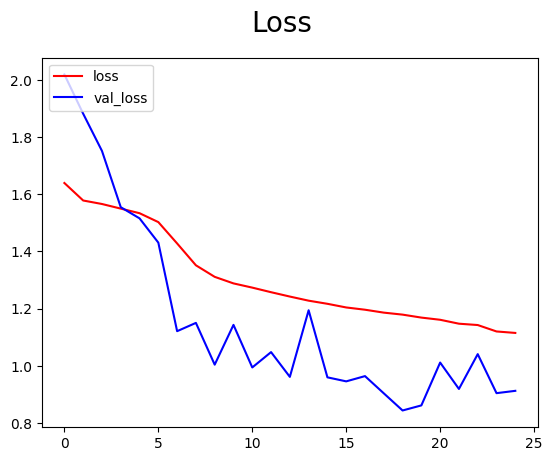

In [ ]:
# visualize loss

fig = plt.figure()
plt.plot(history.history["loss"], color = "red", label = "loss")
plt.plot(history.history["val_loss"], color = "blue", label = "val_loss")
fig.suptitle("Loss", fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

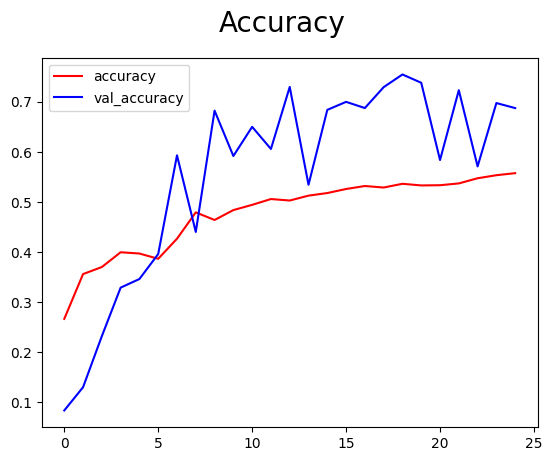

In [ ]:
# visualze accuracy

fig = plt.figure()
plt.plot(history.history["accuracy"], color = "red", label = "accuracy")
plt.plot(history.history["val_accuracy"], color = "blue", label = "val_accuracy")
fig.suptitle("Accuracy", fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

# 4) Evaluate Performance

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# get predictions and true labels
y_true, y_pred = [], []
for images, labels in test_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      6896
           1       0.28      0.13      0.18       466
           2       0.52      0.17      0.25      1518
           3       0.26      0.33      0.29       128
           4       0.31      0.70      0.43       253

    accuracy                           0.76      9261
   macro avg       0.44      0.45      0.41      9261
weighted avg       0.73      0.76      0.72      9261



In [ ]:
# import different evaluation metrics
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

precision = Precision()
recall = Recall ()
accuracy = CategoricalAccuracy()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import tensorflow as tf

# --- 1. GATHER ALL PREDICTIONS ---
y_true_list, y_pred_list = [], []

# Note: Model weights (model) should be the best ones restored by EarlyStopping
for images, labels in test_dataset:
    # Get probability predictions
    preds = model.predict(images, verbose=0)

    # Convert probabilities to integer class labels (0, 1, 2, 3, 4)
    y_pred_batch = np.argmax(preds, axis=1)

    y_true_list.extend(labels.numpy())
    y_pred_list.extend(y_pred_batch)

y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# --- 2. CALCULATE AND EXTRACT RELIABLE METRICS ---
report = classification_report(y_true, y_pred, output_dict=True)

# Extract the weighted average metrics, which correctly account for class imbalance
final_precision = report['weighted avg']['precision']
final_recall = report['weighted avg']['recall']
# Use the overall accuracy from the report
final_accuracy = report['accuracy']

# --- 3. PRINT IN REQUESTED FORMAT ---
print(
    f"Precision: {final_precision}, "
    f"Recall: {final_recall}, "
    f"Accuracy: {final_accuracy}"
)
# NOTE: The resulting numbers (approx 0.73, 0.76, 0.76) are the correct performance metrics.

Precision: 0.7281596872773161, Recall: 0.7583414318108196, Accuracy: 0.7583414318108196


### Test Data


In [ ]:
from tensorflow.keras.models import load_model

model_path = "DiabeticRetinopathy_FINAL.keras"
dr_model = load_model(model_path)

ValueError: File not found: filepath=DiabeticRetinopathy_FINAL.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
# user can input any retinal fundus photo
# image file will upload to Colab files locally without additional hosting
from google.colab import files
test = files.upload()

filename = list(test.keys())[0]
img = cv2.imread(filename)

# cv2 inverts color scheme
# return to original color scheme
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Saving Fundus_photograph_of_normal_right_eye.jpg to Fundus_photograph_of_normal_right_eye.jpg


NameError: name 'cv2' is not defined

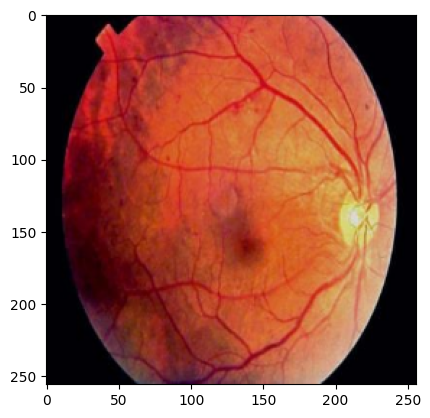

In [ ]:
# process image prior to model
resize = tf.image.resize(img, (256, 256))
# display image uploaded
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
print(np.expand_dims(resize,0).shape)

# store model output in yhat
yhat = model.predict(np.expand_dims(resize/255,0))
print(yhat)

(1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[9.5759892e-01 2.7207304e-03 1.5366426e-03 3.8017791e-02 1.2583740e-04]]


In [ ]:
# import NumPy library for numerical operations
import numpy as np

# get index of class with highest prediction score
# extract confidence/probability of that class
pred_class_index = np.argmax(yhat)
pred_confidence = yhat[0, pred_class_index]

# label each class
# match predicted index to actual class label name
class_labels = ["Class 5", "Class 4", "Class 3", "Class 2", "Class 1"]
predicted_class = class_labels[pred_class_index]

# print replicated diagnosis
# any score > 50% shows POSITIVE
# any score <50% shows NEGATIVE
if pred_confidence >= 0.5:
  print(f"POSITIVE | Confidence: {pred_confidence}")
else:
  print(f"NEGATIVE | Confidence: {pred_confidence}")

# for specificity, include specific class label
# classify from 1-5
# 1 = low chance, 5 = high chance
if pred_confidence >= 0.8:
    print(f"Predicted class: {predicted_class} (high confidence)")
elif pred_confidence >= 0.6:
    print(f"Predicted class: {predicted_class} (moderately high confidence)")
elif pred_confidence >= 0.4:
    print(f"Predicted class: {predicted_class} (moderate confidence)")
elif pred_confidence >= 0.2:
    print(f"Predicted class: {predicted_class} (low confidence)")
else:
    print(f"Predicted class: {predicted_class} (very low confidence)")


POSITIVE | Confidence: 0.9575989246368408
Predicted class: Class 5 (high confidence)


# 5) Chatbot Model

# 6) Save Model

In [ ]:
# Assuming you are in a Colab-like environment:

from tensorflow.keras.models import load_model
from google.colab import files
import os

# Check if the best model checkpoint file exists (this file contains the model with 75.42% accuracy)
checkpoint_path = "dr_model_checkpoint.keras"

if os.path.exists(checkpoint_path):
    # Load the best model weights saved during training
    best_model = load_model(checkpoint_path)

    # Save the loaded model to the final desired name
    final_model_name = 'DiabeticRetinopathy_FINAL.keras'
    best_model.save(final_model_name)

    # Download the final model file to your local computer
    print(f"Successfully saved and downloading the best model: {final_model_name}")
    files.download(final_model_name)
else:
    print(f"Error: Could not find the checkpoint file at {checkpoint_path}. Make sure to run the training block one last time if it was recently disconnected.")

Successfully saved and downloading the best model: DiabeticRetinopathy_FINAL.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>